# Study of the Supervised Descent Method in Face Alignement

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
import pickle

# Import modules
from src.get_data import get_data
from src.model import SDM
from sklearn.linear_model import Ridge

## Dataset analysis

The first step in order to train the model is to create a training dataset, which will be constitued of picture of faces with a target landmark.


For this we use the `get_data` function: 
- get images from files
- filter out gaces where the face detector doesn't find the correct face
- split the picture in train/test set
- compute the mean face on the train set
- create instance of image through the Image_factory class

The Image_factory class is the main processing before training, it separately treat image if they are test or train. 

For train images:
- compute a bounding box around the face found by the face detector
- perturb the bounding box around its position to have more diverse sample (10 perturbations per original train image)
- in each sample, check if the perturbed bounding box is not too far from the original face with intersection over union of boxes
- put the mean face landmark in the box to initialize the SDM

For tests images:
- find face with face detector
- put a bounding box at the face
- put the mean face in the middle of the box


The training is done over 2000 samples, perturbed from around 700 original image from different dataset, either LPFW or AFW from ibug.

In [32]:
path_afw=r"data\ibug_300W_large_face_landmark_dataset\afw" 
path_lpfw=r"data\ibug_300W_large_face_landmark_dataset\lfpw\trainset"

DATA_PATH=path_lpfw

t0 = time.time()
train_data, test_data, mean_shape = get_data(DATA_PATH, train_split=0.8)
random.shuffle(train_data)
train_data=train_data[:5000]

print('\n')
print(f"Loaded data in {time.time()-t0:.2f} seconds.")
print(f"Number of train pictures : {len(train_data)}")
print(f"Number of test pictures : {len(test_data)}")

Data Cleaning: Kept 757 images. Rejected 54 bad detections.
Data loaded: 605 Train, 152 Test.
Generating augmented training data (10 per image)


Loaded data in 25.51 seconds.
Number of train pictures : 5000
Number of test pictures : 152


## SDM Model



### Training


In [33]:
# Parameters

# Number of step of SDM
n_step=5  

# Regularization parameter in regression model
alpha=1000

# Use previous model already saved
use_saved=False
filename_to_use = "model_alpha100.pkl"

In [34]:
model=Ridge(alpha=alpha) # better than LinearRegression() in order to limit weights with noise
# Fitting
if use_saved:
    with open(filename_to_use, "rb") as f:
        data_loaded = pickle.load(f)
    sdm=data_loaded["model"] 
    mean_shape=data_loaded["mean_shape"]
    sdm.extraction_function=cv2.SIFT_create()

else:
    t0 = time.time()
    sdm=SDM(n_step=n_step,model=model)
    sdm.fit(train_data,test_data)
    print(f"Finished training in {time.time()-t0:.2f} seconds.")


Training SDM on 5000 images for 5 steps.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.81975e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Mean NME  : 0.2359 (23.59%)
Step 1 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.69001e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Mean NME  : 0.1387 (13.87%)
Step 2 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.94388e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Mean NME  : 0.1266 (12.66%)
Step 3 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.56735e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Mean NME  : 0.1231 (12.31%)
Step 4 done.


c:\Users\maloc\miniconda3\envs\env_ML\Lib\site-packages\scipy\_lib\_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=3.10761e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Mean NME  : 0.1213 (12.13%)
Step 5 done.
Finished training in 1451.38 seconds.


In [35]:
# Save instance in order to use again
# useful when fitting was 40 min long!
save=True
filename_to_save="model_alpha1000.pkl"

# Save model
if save:
    # need to remove the extraction function because pickle cannot save them, it is reset just after
    sdm.extraction_function = None
    sauvegarde = {"model": sdm,"mean_shape": mean_shape}
    with open(filename_to_save, "wb") as f:
        pickle.dump(sauvegarde, f)
    sdm.extraction_function=cv2.SIFT_create()

### Visualization

Test in image 58


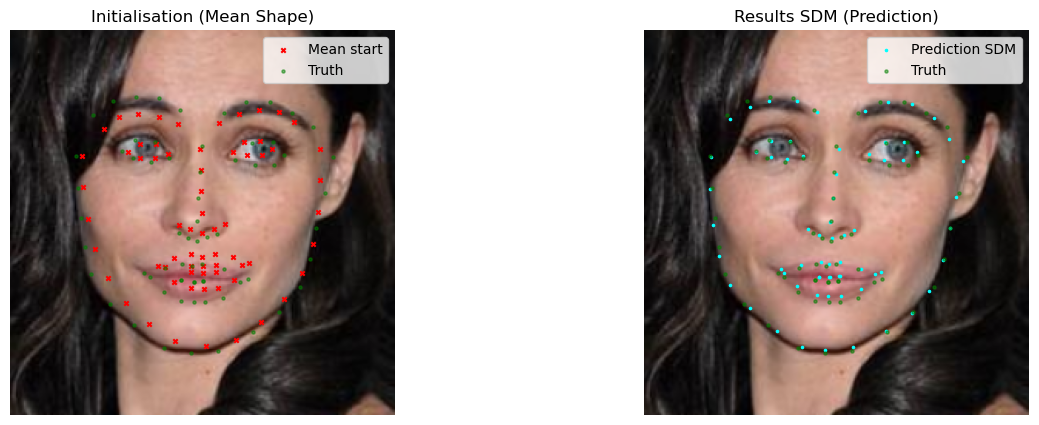

Test in image 119


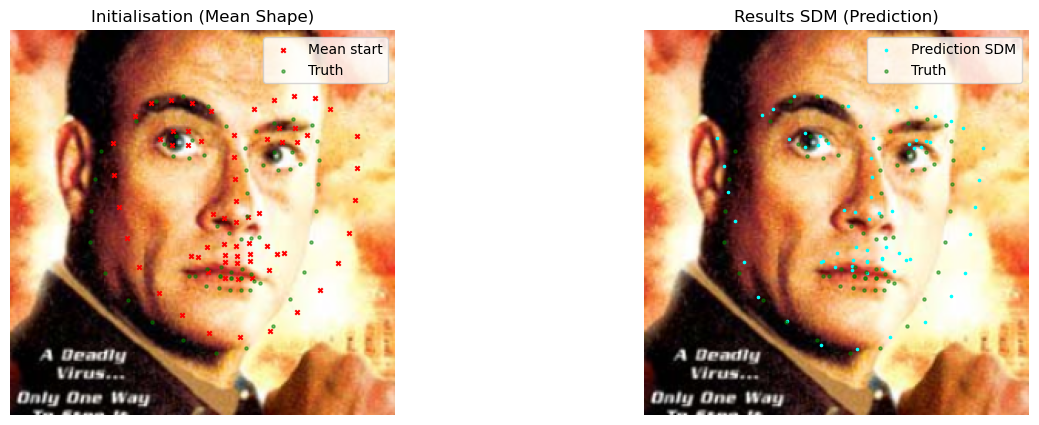

Test in image 145


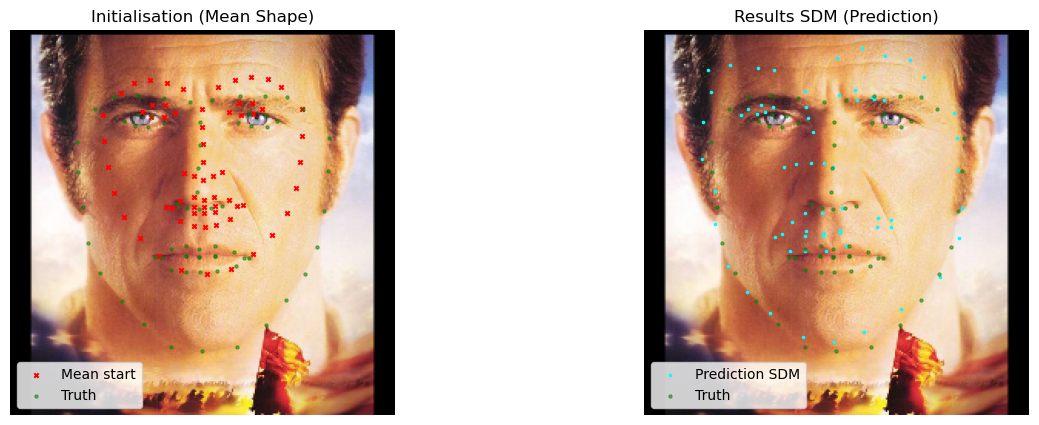

Test in image 33


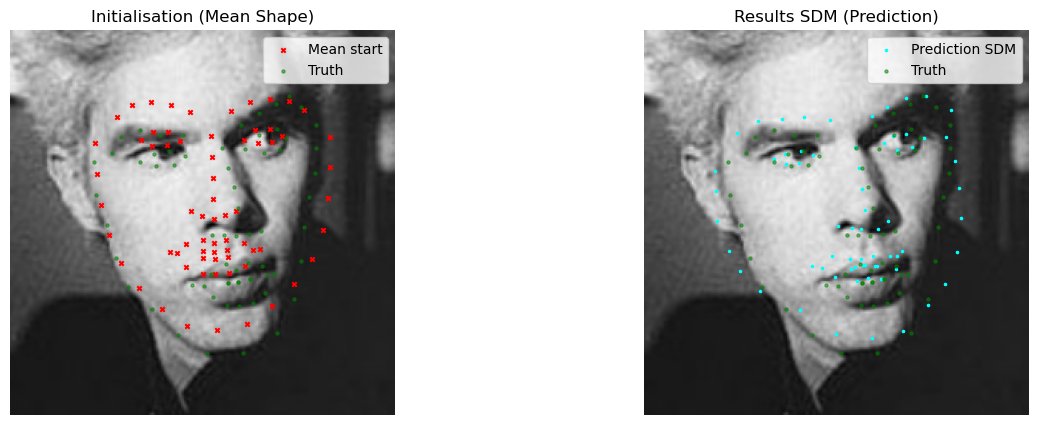

Test in image 8


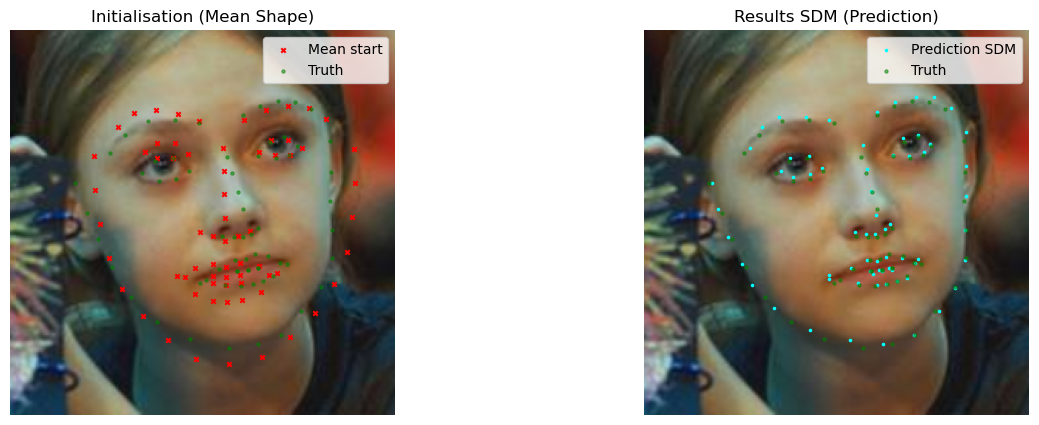

In [36]:
def visualize_result(sdm, image_obj):
    """
    Plot predictedd landmarks:
        Green is the true landmark (labels)
        Red is the mean face landmarks
        Blue is the predicted landmarks with SDM
    """
    # Predict new image
    predicted_image=sdm.predict(image_obj)
    predicted_landmark=predicted_image.current_landmark
    
    
    plt.figure(figsize=(15, 5))
    
    # Image before optimization
    plt.subplot(1, 2, 1)
    plt.title("Initialisation (Mean Shape)")
    if len(image_obj.image.shape) == 3:
        plt.imshow(cv2.cvtColor(image_obj.image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_obj.image, cmap='gray')
        
    plt.scatter(image_obj.current_landmark[:, 0], image_obj.current_landmark[:, 1], 
                c='red', s=10, marker='x', label='Mean start')
    plt.scatter(image_obj.true_landmark[:, 0], image_obj.true_landmark[:, 1], 
                c='green', s=5, alpha=0.5, label='Truth')
    plt.legend()
    plt.axis('off')

    # Image after optimization
    plt.subplot(1, 2, 2)
    plt.title("Results SDM (Prediction)")
    if len(image_obj.image.shape) == 3:
        plt.imshow(cv2.cvtColor(image_obj.image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image_obj.image, cmap='gray')
    plt.scatter(predicted_landmark[:, 0], predicted_landmark[:, 1], 
                c='cyan', s=10, marker='.', label='Prediction SDM')
    plt.scatter(image_obj.true_landmark[:, 0], image_obj.true_landmark[:, 1], 
                c='green', s=5, alpha=0.5, label='Truth')
    plt.legend()
    plt.axis('off')
    
    plt.show()

for i in range(5):
    idx=random.randint(1,len(test_data))
    print(f"Test in image {idx}")
    visualize_result(sdm, test_data[idx])

## Performances

### Test score

Compute the Normalized mean Error over the test set to plot cumulative distribution or evolution with training.

Mean NME  : 0.1213 (12.13%)
Global Score  : 0.1213


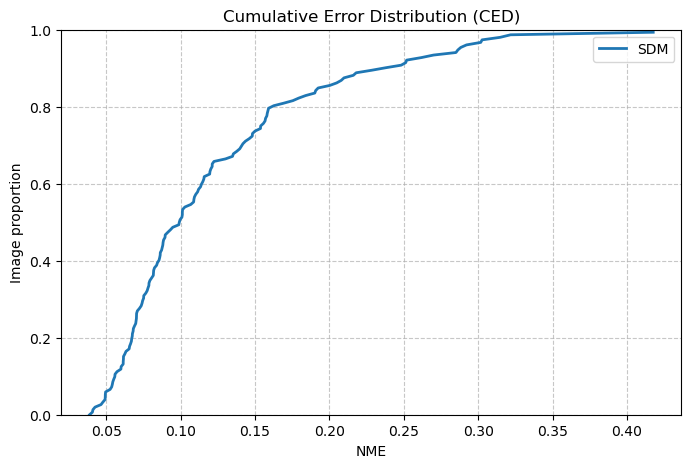

In [37]:
#Scores
final_score, all_errors,=sdm.evaluate(test_data)

print(f"Global Score  : {final_score:.4f}")
sorted_errors = np.sort(all_errors)
proportions = np.arange(len(sorted_errors)) / len(sorted_errors)

plt.figure(figsize=(8, 5))
plt.plot(sorted_errors, proportions, label='SDM', linewidth=2)

plt.title("Cumulative Error Distribution (CED)")
plt.xlabel("NME")
plt.ylabel("Image proportion")
plt.grid(True, which='both', linestyle='--', alpha=0.7)

plt.ylim(0, 1.0)
plt.legend()

plt.show()

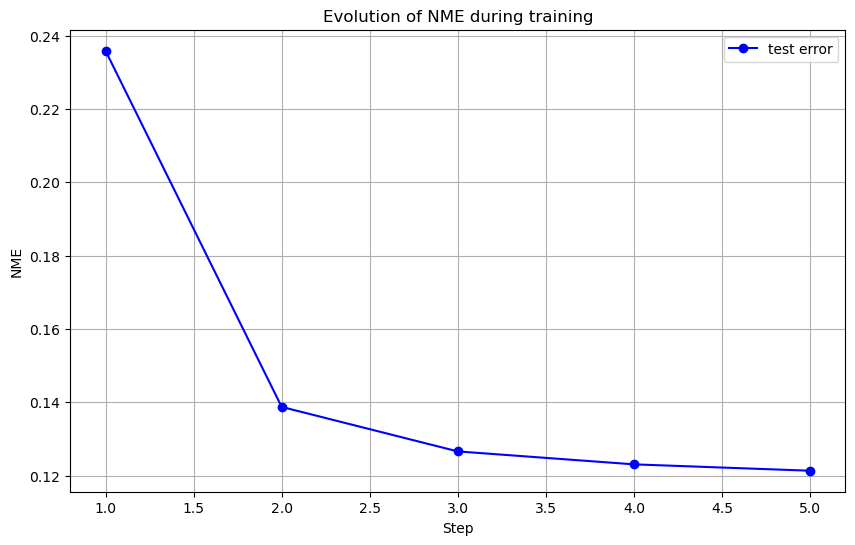

In [38]:
errors=sdm.graph_nme_hist()

### Error analysis

Get worst failures of the model by NME, this is particularly useful to calibrate the model and fix issue in the first step. Seeing that most big errors were from defect of the face detector prompted me to crop image at the source and only use boxes.

Worst 3 failures
Image Index 0 - Erreur NME: 0.2359


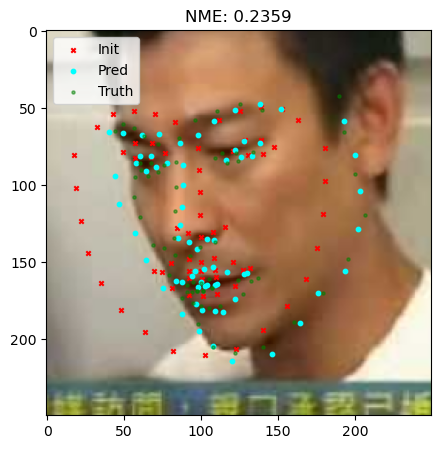

Image Index 1 - Erreur NME: 0.1387


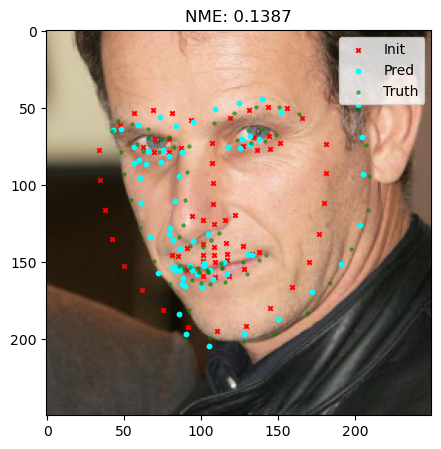

Image Index 2 - Erreur NME: 0.1266


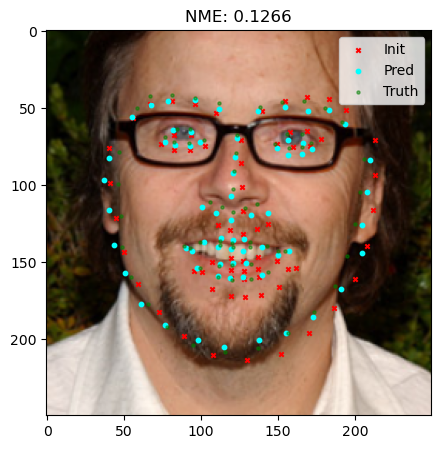

In [39]:
def show_worst_failures(model, test_data,all_errors, n=3):
    worst_indices = np.argsort(all_errors)[::-1][:n]
    print(f"Worst {n} failures")
    
    for idx in worst_indices:
        img_obj = test_data[idx]
        score = all_errors[idx]
        
        print(f"Image Index {idx} - Erreur NME: {score:.4f}")
        pred_img = model.predict(img_obj)
        
        plt.figure(figsize=(10, 5))
        if len(img_obj.image.shape) == 3:
            plt.imshow(cv2.cvtColor(img_obj.image, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img_obj.image, cmap='gray')

        plt.scatter(img_obj.current_landmark[:, 0], img_obj.current_landmark[:, 1], 
                    c='red', s=10, marker='x', label='Init')
        plt.scatter(pred_img.current_landmark[:, 0], pred_img.current_landmark[:, 1], 
                    c='cyan', s=10, label='Pred')
        plt.scatter(img_obj.true_landmark[:, 0], img_obj.true_landmark[:, 1], 
                    c='green', s=5, alpha=0.5, label='Truth')
        
        plt.legend()
        plt.title(f"NME: {score:.4f}")
        plt.show()

show_worst_failures(sdm, test_data,errors)


--- Pixels results ---
Mean Error: 8.38 pixels
Worst error in a single example : 32.97 pixels
Index of worst image : 121
Worst image sample :


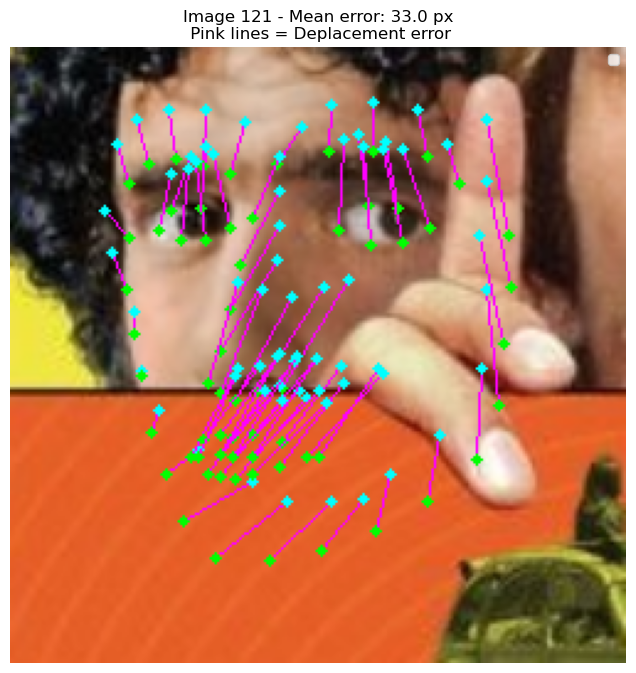

Random sample:


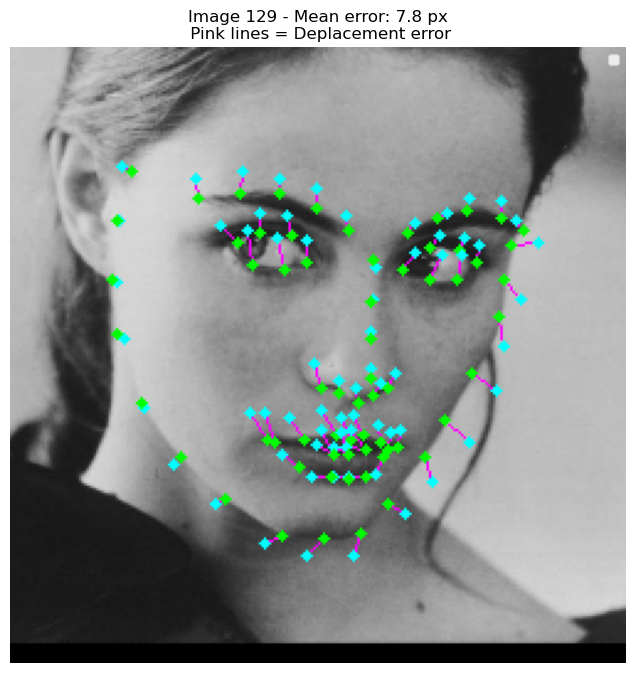

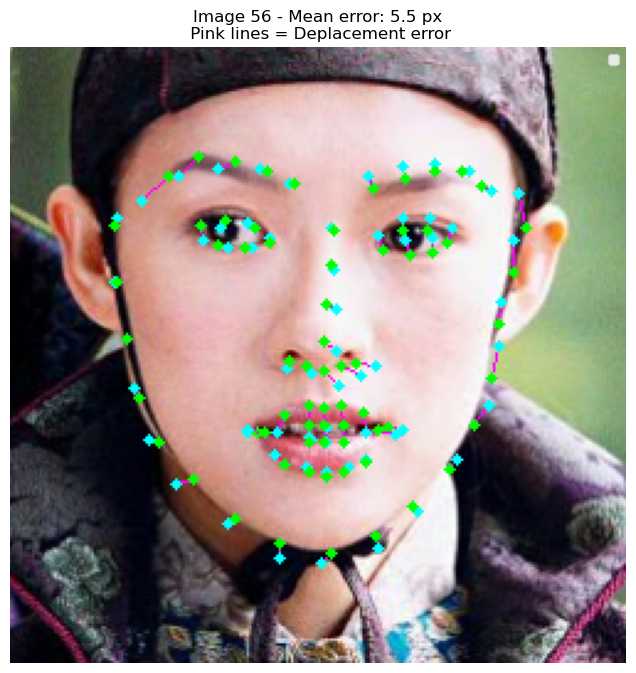

In [40]:
mean_px, errors_per_image, worst_idx, max_error=sdm.evaluate_in_pixels(test_data)
print(f"\n--- Pixels results ---")
print(f"Mean Error: {mean_px:.2f} pixels")
print(f"Worst error in a single example : {max_error:.2f} pixels")
print(f"Index of worst image : {worst_idx}")
# See vector on worst sample
print("Worst image sample :")
sdm.visualize_error_vectors(test_data, image_indices=[worst_idx])

# vectors on random samples
print("Random sample:")
sdm.visualize_error_vectors(test_data)

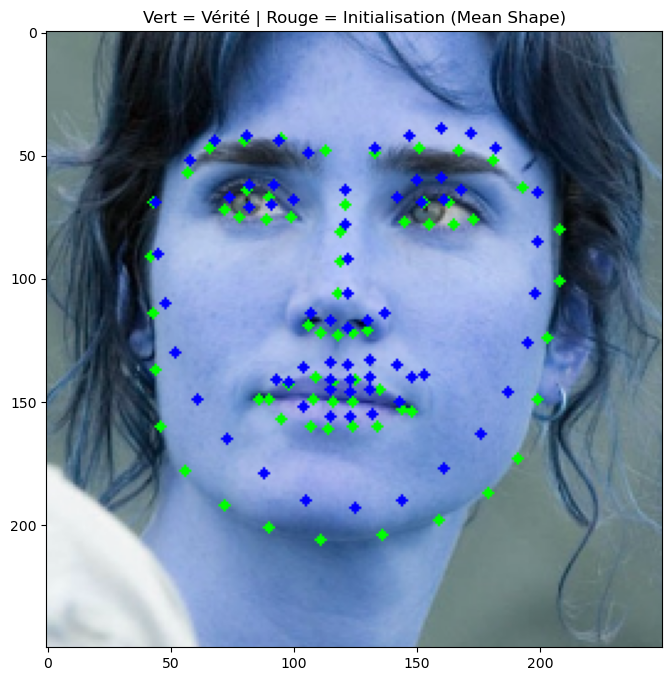

In [41]:
def debug_initialization(image_obj, mean_shape):
    """
    Affiche l'image, le vrai landmark (Vert) et l'initialisation (Rouge)
    """
    # Si ton image est en N&B, on la passe en RGB pour dessiner en couleur
    if len(image_obj.image.shape) == 2:
        canvas = cv2.cvtColor(image_obj.image, cv2.COLOR_GRAY2RGB)
    else:
        canvas = image_obj.image.copy()

    # Vrai landmark (Vérité terrain)
    for (x, y) in image_obj.true_landmark:
        cv2.circle(canvas, (int(x), int(y)), 2, (0, 255, 0), -1) # Vert

    # Landmark initial (Mean Shape placée au centre ou scalée)
    # C'est ce que ton modèle voit AVANT le step 1
    for (x, y) in image_obj.current_landmark:
        cv2.circle(canvas, (int(x), int(y)), 2, (0, 0, 255), -1) # Rouge

    plt.figure(figsize=(8,8))
    plt.imshow(canvas)
    plt.title("Vert = Vérité | Rouge = Initialisation (Mean Shape)")
    plt.show()

# Teste sur une image du Train ou du Test
debug_initialization(test_data[10], None)

# Test on own data

In [ ]:
def preprocess_test_image(img, bbox, target_size=250, padding=0.5):

    x, y, w, h = bbox

    center_x = x + w / 2
    center_y = y + h / 2
    face_size = max(w, h) # On prend le carré max

    crop_size = face_size * (1 + padding)
    
    x1 = int(center_x - crop_size / 2)
    y1 = int(center_y - crop_size / 2)
    x2 = int(x1 + crop_size)
    y2 = int(y1 + crop_size)
    h_img, w_img = img.shape[:2]
    pad_x1 = max(0, -x1)
    pad_y1 = max(0, -y1)
    pad_x2 = max(0, x2 - w_img)
    pad_y2 = max(0, y2 - h_img)
    img_padded = cv2.copyMakeBorder(img, pad_y1, pad_y2, pad_x1, pad_x2, cv2.BORDER_CONSTANT)

    x1_pad = x1 + pad_x1
    y1_pad = y1 + pad_y1
    
    face_crop = img_padded[y1_pad : y1_pad + int(crop_size), x1_pad : x1_pad + int(crop_size)]
    
    # 5. Resize final (250x250)
    
    face_resized = cv2.resize(face_crop, (target_size, target_size))


    scale = target_size / crop_size 
    

    offset_x = x1
    offset_y = y1
    
    inverse_info = {
        'scale': scale,
        'offset_x': offset_x,
        'offset_y': offset_y
    }
    
    return face_resized, inverse_info

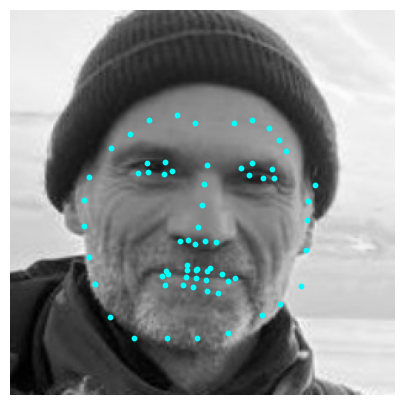

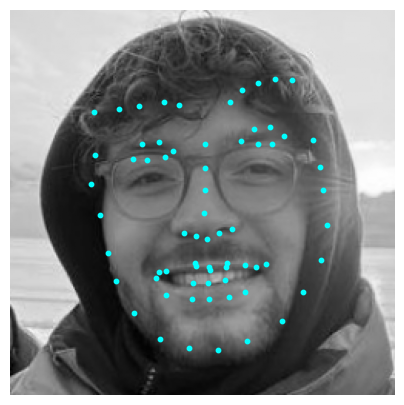

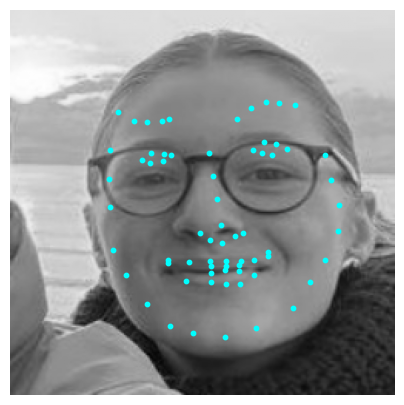

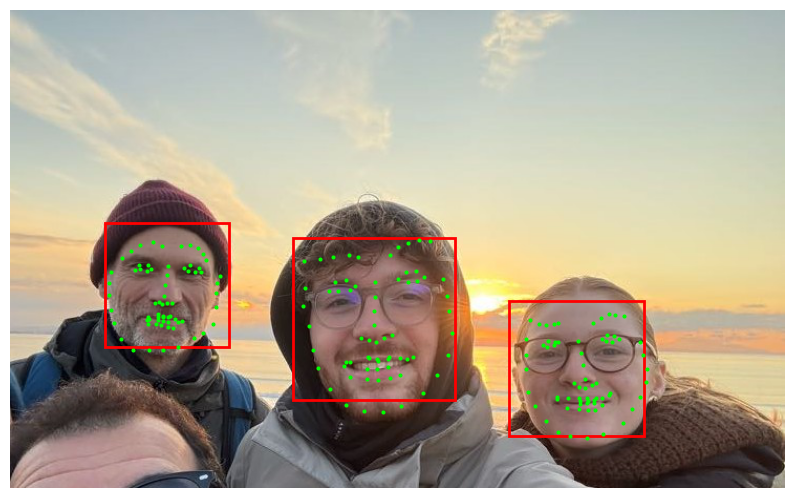

In [62]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from src.image import Image

img_path = r"data/img_perso.jpg"
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(r"src\haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(img_gray, 1.1, 5)

if len(faces) > 0:
    global_results = []

    for bbox in faces:
        processed_img, info = preprocess_test_image(img_gray, bbox, target_size=250, padding=0.5)
        
        if processed_img is not None:
            h_p, w_p = processed_img.shape
            processed_bbox = (0, 0, w_p, h_p) 
            
            img_obj = Image(processed_img, None, processed_bbox)

            center_x = w_p / 2
            center_y = h_p / 2 + (h_p * 0.10)
            
            img_obj.current_landmark = mean_shape + [center_x, center_y]
            
            res = sdm.predict(img_obj)
            pred_lm_local = res.current_landmark

            plt.figure(figsize=(5,5))
            plt.imshow(processed_img, cmap='gray')
            plt.scatter(pred_lm_local[:, 0], pred_lm_local[:, 1], s=10, c='cyan')
            plt.axis('off')
            plt.show()

            scale = info['scale']
            off_x = info['offset_x']
            off_y = info['offset_y']
            
            pred_lm_global = (pred_lm_local / scale) + np.array([off_x, off_y])
            global_results.append((bbox, pred_lm_global))

    plt.figure(figsize=(10,10))
    plt.imshow(img_rgb)

    for bbox, landmarks in global_results:
        rx, ry, rw, rh = bbox
        rect = plt.Rectangle((rx, ry), rw, rh, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=15, c='lime', marker='.')

    plt.axis('off')
    plt.show()

else:
    print("No face detected.")